<a href="https://colab.research.google.com/github/aditijais05/diabetes-prediction-model/blob/main/diabetes_prediction_using_boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required libs (Colab has pip + internet)
!pip install -q xgboost lightgbm catboost

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt

# Helper to display DataFrame nicely in Colab
from IPython.display import display


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.8 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
path = "/content/drive/MyDrive/datasets/diabetes.csv"
df = pd.read_csv(path)

df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
# In Pima dataset some fields are recorded as 0 meaning missing (Glucose, BP, Skin, Insulin, BMI).
cols_with_zero = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]

for col in cols_with_zero:
    nonzero_median = df.loc[df[col] != 0, col].median()
    df.loc[df[col] == 0, col] = nonzero_median

# Features and target
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# Scale (recommended for LR and tree-based models it's optional but consistent)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (614, 8) Test size: (154, 8)


In [6]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0, random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

results = {}
y_probs = {}
y_preds = {}

for name, model in models.items():
    # Use scaled features
    model.fit(X_train_s, y_train)
    preds = model.predict(X_test_s)
    probs = model.predict_proba(X_test_s)[:,1]
    acc = accuracy_score(y_test, preds)
    results[name] = acc
    y_probs[name] = probs
    y_preds[name] = preds
    print(f"{name}: accuracy = {acc:.4f}")


Logistic Regression: accuracy = 0.7078
Random Forest: accuracy = 0.7403
XGBoost: accuracy = 0.7597
[LightGBM] [Info] Number of positive: 214, number of negative: 400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 664
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348534 -> initscore=-0.625489
[LightGBM] [Info] Start training from score -0.625489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


CatBoost: accuracy = 0.7403


In [7]:
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['accuracy']).sort_values(by='accuracy', ascending=False)
display(results_df)

best_name = results_df.index[0]
best_acc = results_df.iloc[0,0]
print(f"\nBest model: {best_name} with accuracy = {best_acc:.4f}")


,accuracy
XGBoost,0.759740
LightGBM,0.746753
Random Forest,0.740260
CatBoost,0.740260
Logistic Regression,0.707792



Best model: XGBoost with accuracy = 0.7597


Classification report for best model:

              precision    recall  f1-score   support

           0     0.8000    0.8400    0.8195       100
           1     0.6735    0.6111    0.6408        54

    accuracy                         0.7597       154
   macro avg     0.7367    0.7256    0.7301       154
weighted avg     0.7556    0.7597    0.7568       154

Confusion matrix (rows=true, cols=pred):


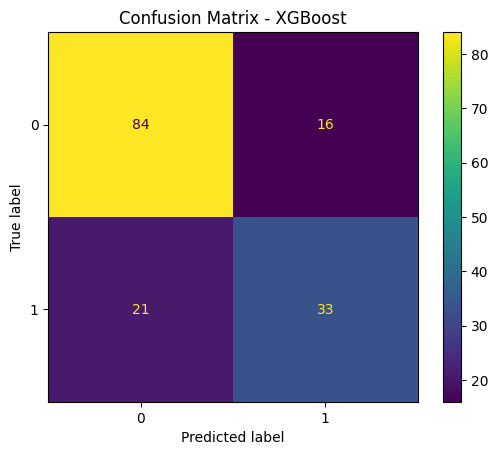

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay

best_preds = y_preds[best_name]
print("Classification report for best model:\n")
print(classification_report(y_test, best_preds, digits=4))

print("Confusion matrix (rows=true, cols=pred):")
cm = confusion_matrix(y_test, best_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title(f"Confusion Matrix - {best_name}")
plt.show()


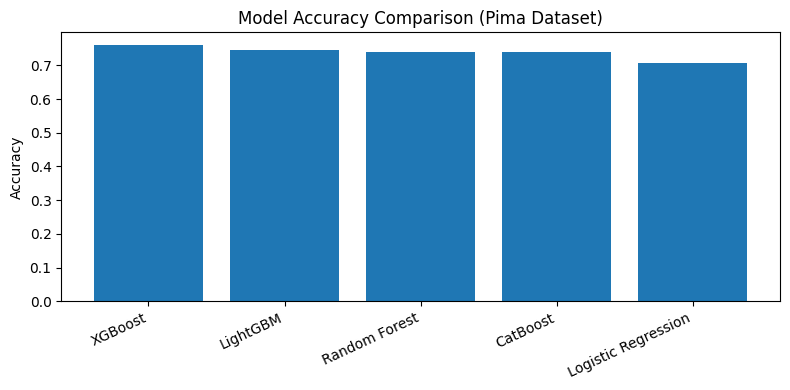

In [9]:
plt.figure(figsize=(8,4))
plt.bar(results_df.index, results_df['accuracy'])
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison (Pima Dataset)")
plt.xticks(rotation=25, ha='right')
plt.tight_layout()
plt.show()


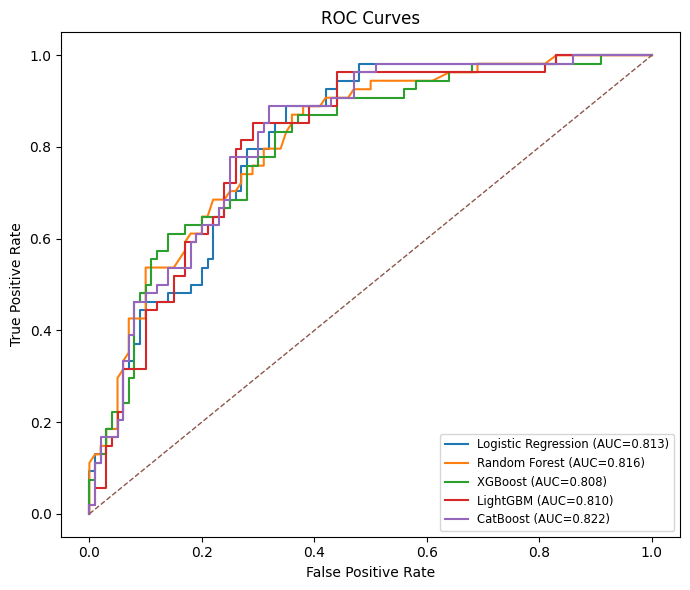

In [10]:
plt.figure(figsize=(7,6))
for name, probs in y_probs.items():
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1], linestyle='--', linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right", fontsize='small')
plt.tight_layout()
plt.show()


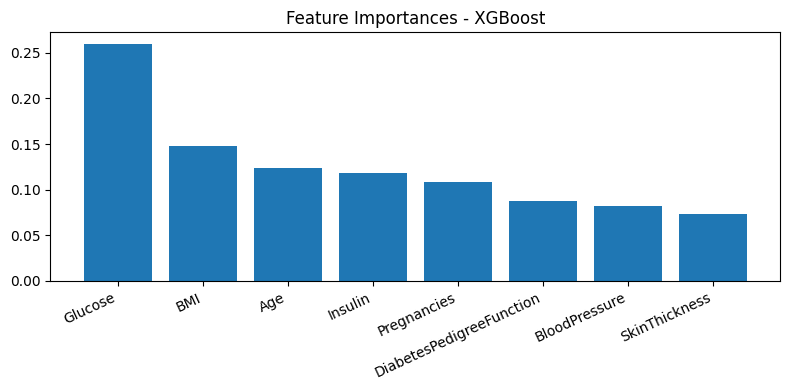

In [11]:
feature_names = X.columns.tolist()
best_model = models[best_name]
importances = None

if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
elif best_name == "Logistic Regression":
    importances = np.abs(best_model.coef_[0])
elif best_name == "CatBoost":
    try:
        importances = best_model.get_feature_importance()
    except:
        importances = None

if importances is not None:
    idx = np.argsort(importances)[::-1]
    plt.figure(figsize=(8,4))
    plt.bar([feature_names[i] for i in idx], importances[idx])
    plt.title(f"Feature Importances - {best_name}")
    plt.xticks(rotation=25, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Feature importances not available for", best_name)
